# Audio Match Sonification
Load an audio file, extract the key. Load an image, convert to audio with a musical inverse spectrogram technique (using additive synthesis). Use the audio key to set the frequencies of the image sonification so that it can be combined with the original audio. 

Using major or minor pentatonic will help reduce dissonance in general. It also helps when the key finder is wrong by a perfect 4th or 5th, which is probably the most common error. 

TO DO: 
- build in tempo, key signature finder
- write better algorithm for mixing the signals (for the actual app, they shoudl be able to adjust the mix in real time and do volume automation, then it would get bounced down to a single file when they export)

In [1]:
from subroutines import *

## Convert mp3 to wave (needed later)

In [2]:
from os import path
from pydub import AudioSegment

audio_filename='electric-feel' #should be G# major, 103bpm, 6/4

# audio_filename='sweet-home-alabama' #should be G major, 98bpm, 4/4

audio_format = '.mp3' #.wav or .mp3

audio_path = './songs/' + audio_filename + audio_format

# convert wav to mp3                                                            
# sound = AudioSegment.from_mp3(audio_path_mp3)
# sound.export(audio_path_wav, format="wav")

#wav to mp3: 
#AudioSegment.from_wav("/input/file.wav").export("/output/file.mp3", format="mp3")



## Load song
Song class finds the likely key and tempo

In [6]:

song = Song(audio_path) #loads song, finds key and tempo


/Users/mattrusso/opt/miniconda3/lib/python3.9/site-packages/librosa/util/decorators.py:88: UserWarning: PySoundFile failed. Trying audioread instead.
  return f(*args, **kwargs)


likely key: G# major, correlation: 0.812


## Generate note frequencies from the extracted key

In [5]:
start_octave = 3 #keep it kind of high to not clash as much
n_octaves = 3
    
freqs = get_scale_freqs(start_note=song.root + str(start_octave), octaves=n_octaves, scale=song.scale)


## Load image 
Reduce vertical resolution to number of notes

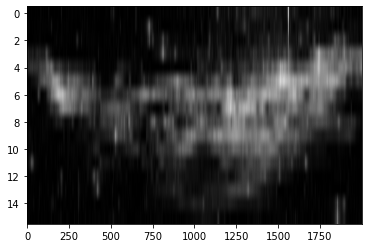

In [8]:
from PIL import Image

image_filename = 'carina_nircam_g' #name of jpg file
image_path = './images/'+image_filename+'.jpg'

img = Image.open(image_path) 
img = boost_contrast(img) #makes structure easier to hear

imgR = img.resize(size = (img.width,len(freqs)), resample=Image.LANCZOS) 
pixels = np.array(imgR.convert('L'))/255 #normalize

plt.imshow(pixels,aspect='auto',cmap='gray')

## Sonify

In [10]:

beats_per_bar = 4 #assume 4/4, doesn't matter much
time_per_bar = beats_per_bar*60/song.tempo
n_bars = 8
duration = n_bars*time_per_bar #seconds, need to set with tempo, key signature and # of bars

print(round(duration,2),'seconds')

wave_sonif = additive_synth(pixels, freqs, song.sr, duration)
wave_sonif.make_audio()

18.58 seconds


(207.65234878997256, 1661.2187903197805)

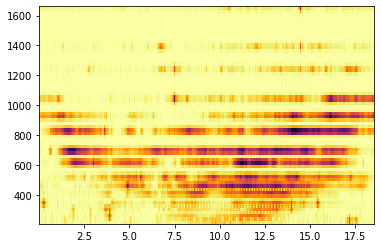

In [19]:
spec = wave_sonif.make_spectrogram(seg_length=1000)
spec.plot()
plt.ylim(min(freqs),max(freqs))

## Combine (poorly) with orignial song to test harmony
Just copying sonification as many times as it will fit cleanly

In [11]:
if '.wav' in audio_path:
    wave_song = read_wave(audio_path)
elif '.mp3' in audio_path:
    try:
        wave_song = read_wave(audio_path.strip('mp3') + 'wav')
    except:
        sound = AudioSegment.from_mp3(audio_path)
        sound.export(audio_path.strip('mp3') + 'wav', format="wav")
        wave_song = read_wave(audio_path.strip('mp3') + 'wav')
        
mix = 0.4 #0 to 1 

wave_mix = wave_song.copy()
n_samp = 0
n_sonf_samp = len(wave_sonif.ts)
while n_samp<len(wave_song.ts)- n_sonf_samp:
    wave_mix.ys[n_samp:n_samp + n_sonf_samp] = (1 - mix)*wave_song.ys[n_samp:n_samp + n_sonf_samp] + mix*wave_sonif.ys
    n_samp += len(wave_sonif.ts)
wave_mix.make_audio()

(195.99771799087466, 1567.981743926997)

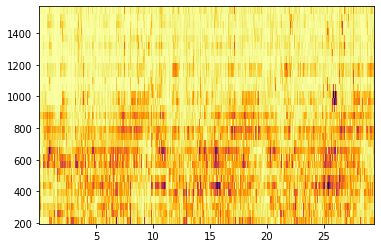

In [ ]:
spec = wave_mix.make_spectrogram(seg_length=1000)
spec.plot()
plt.ylim(min(freqs),max(freqs))

## Save mix

In [21]:
wave_mix.normalize(0.9)
wave_mix.write('./mixes/' + audio_filename + ' + ' +image_filename + '.wav')

Writing ./mixes/electric-feel + carina_nircam_g.wav


'/audio/sweet-home-alabama.wav'